# Movies

_We live in a box of space and time. Movies are windows in its walls. They allow us to enter other minds, not simply in the sense of identifying with the characters, although that is an important part of it, but by seeing the world as another person sees it._ - Roger Ebert

## Setup and data cleaning

Caveat: split years....

In [1]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from numpy import NaN
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import movies (IMDB)
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data (BoxOfficeMojo)
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data (https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films)
oscars = pd.read_csv('../data/oscars_cleaned.csv')

In [95]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [96]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [178]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

In [179]:
# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

# Drop, rename, change \N to NaN
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})
combined = combined.replace(r'\\N','NaN', regex=True)
combined = combined[combined['Runtime (min)']!='NaN']
combined = combined[combined['Genre (main)']!='NaN']

# Convert NaN to 0 for Awards and Nominiations
combined['Awards']=combined['Awards'].fillna(0)
combined['Nominations']=combined['Nominations'].fillna(0)

In [180]:
## Drop items we don't have data for (i.e. Studio or Gross (lifetime) data)
dropped = combined.dropna(axis='rows')
dropped.count()

Title               19562
Year                19562
Runtime (min)       19562
Genre (main)        19562
Rating (avg.)       19562
Votes               19562
Studio              19562
Gross (lifetime)    19562
Awards              19562
Nominations         19562
dtype: int64

In [181]:
# Reset index to avoid sklearn problems
dropped = dropped.reset_index()
dropped = dropped.drop(['index'], axis=1)
dropped['Votes'] = dropped['Votes'].astype(int)
dropped['Awards'] = dropped['Awards'].astype(int)
dropped['Nominations'] = dropped['Nominations'].astype(int)
dropped['Gross (lifetime)'] = dropped['Gross (lifetime)'].astype(int)

In [182]:
## Identify duplicates titles – FIX SO AWARD DATA NOT LOST
#dropped['Duplicate'] = dropped['Title'].duplicated()
#dropped = dropped[dropped['Duplicate']==True]
#dropped.count()

In [183]:
# List out genres
genre_list = dropped['Genre (main)'].unique()
genre_list

array(['Biography', 'Drama', 'Western', 'Action', 'Mystery', 'Comedy',
       'Adventure', 'Horror', 'Fantasy', 'Romance', 'Documentary',
       'Crime', 'Musical', 'Sci-Fi', 'Animation', 'Film-Noir', 'Family',
       'Thriller', 'Music', 'History', 'War', 'Sport'], dtype=object)

In [184]:
## REFACTOR: Condense/find more efficient way to do this, possibly: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
## Code genres numerically
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Action',1, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Adventure',2, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Animation',3, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Biography',4, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Comedy',5, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Crime',6, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Drama',7, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Documentary',8, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Family',9, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Fantasy',10, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Film-Noir',11, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'History',12, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Horror',13, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Music',14, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Musical',15, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Mystery',16, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Romance',17, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sci-Fi',18, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sport',19, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Thriller',20, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'War',21, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Western',22, regex=True)

In [185]:
# Drop the studios. There are a lot, and we're not using them right now
dropped = dropped.drop(['Studio'], axis=1)
dropped.head()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Gross (lifetime),Awards,Nominations
0,Passion,1919,85,4,6.8,732,92181,0,0
1,The Count of Monte Cristo,1913,69,7,5.6,37,54234062,0,0
2,The Escape,1914,60,7,5.9,15,12074,0,0
3,Jane Eyre,1914,50,7,6.6,7,11242660,0,0
4,The Birth of a Nation,1915,195,7,6.4,21494,15861566,0,0


# Machine Learning 1: Regression

In [211]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

Shape:  (19562, 1) (19562, 1)


Text(0, 0.5, 'Votes')

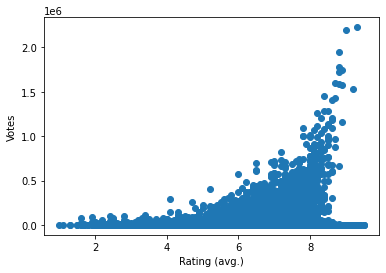

In [212]:
# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

In [192]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [193]:
# Drop NaN
X = X[np.logical_not(np.isnan(X))]
y = y[np.logical_not(np.isnan(y))]

In [194]:
# Create model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [195]:
# Fit model to training data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [196]:
# Calculate mean_squared_error and r-squared value for testing data
from sklearn.metrics import mean_squared_error, r2_score

# Use model to make predictions
predicted = model.predict(X_test)

# Score predictions
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 8048858893.161272
R-squared (R2): 0.050909694829912255


In [197]:
# Show r2 score for model
model.score(X_test, y_test)

0.050909694829912255

In [198]:
# Score and print scores
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training score: {training_score}")
print(f"Testing score: {testing_score}")

Training score: 0.058004816608874805
Testing score: 0.050909694829912255


Text(0.5, 1.0, 'Residual plot')

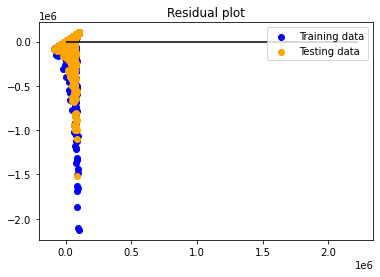

In [199]:
# Plot residuals
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual plot")

# Machine Learning 2: Multiple Linear Regression

In [213]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

Shape:  (19562, 1) (19562, 1)


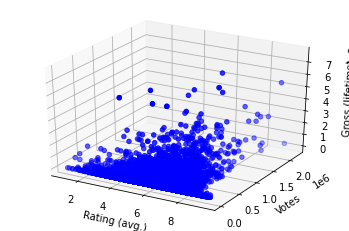

In [214]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dropped['Rating (avg.)']
y = dropped['Votes']
z = dropped['Gross (lifetime)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Rating (avg.)')
ax.set_ylabel('Votes')
ax.set_zlabel('Gross (lifetime)')

plt.show()

In [202]:
# Note: The weights are how important each feature is to the equation. This is the part that the algorithm has to learn. Multiple Linear Regression simply means that you have more than one feature variable.
# Generate a linear dataset with three features

from sklearn.datasets import make_regression

n_features = 3
X, y = make_regression(n_samples=30, n_features=n_features, n_informative=n_features, random_state=42,  noise=0.5, bias=100.0)
print(X.shape)

(30, 3)


In [203]:
# We can still visualize 3 features as a 3D plot, but what about n-dimensions? This becomes very difficult for the human brain to visualize.
# We could pick just one feature from X to fit our model, but what we really want it to find a line that best fits the data in n-dimensional space. To achieve this, Linear Regression can be solved using the analytical approach called Ordinary Least Squares or a computational approach Gradient Descent for estimating the parameters. Note that there are tradeoffs between using either approach. The Linear Regression model in Sklearn uses the Ordinary Least Squares method.
# Luckily, we can just supply our n-dimensional features and sklearn will fit the model using all of our features.

from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.9999838079561165


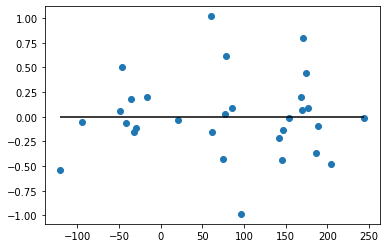

In [204]:
# Because we can't easily plot our line in 3D space, we can use a residual plot to check our predictions. Residuals are the difference between the true values of y and the predicted values of y.
# We want our predictions to be close to zero on the y-axis in this plot.

predictions = model.predict(X)

# Plot residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

## Backlog

In [172]:
## Do stuff w/genres
## REFACTOR: Break out documentary and animation
# TODO: VOTES X GROSS, RATING X AWARDS, RATING X GROSS, GENRES, STUDIO X AWARDS
# Calculate avg gross ($) per movie
#box_plot['Avg. lifetime gross'] = box_plot['lifetime_gross']/box_plot['title']

My plan for tomorrow is to put together a few examples for both regression sections, mostly bringing in analysis with award and genre data
I also would like to go through the data set some how – there are duplicates in there, and I’d like to filter them (while not losing important data). I might ask Nate’s help when we meet, or if folks have thoughts on good ways of doing this, HMU
It may not be critical…would be good, but I want to make sure the analyses are in a good place first
I’m really seeing how much of data work is bringing together data in a useful way, cleaning, etc. I’d still like to integrate country and maybe studio data, but that might have to wait for another project…

In [169]:
## More data: Budget, Country (e.g. most popular genres by country)

## TODO: FIND MOST COMMON STUDIOS?? CODE?
# List out studios
#studio_list = dropped['Studio'].unique()
#studio_list